In [0]:
# TO display images
%matplotlib inline
# fastai library sits on top of pytorch
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
!pip install kaggle

- Lets bring in the data from kaggle cactus challenge

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [0]:
!kaggle competitions download -c Aerial-Cactus-Identification

 26% 5.00M/19.2M [00:00<00:00, 35.6MB/s]
100% 19.2M/19.2M [00:00<00:00, 93.9MB/s]
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 208MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 142MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 129MB/s]


In [0]:
!unzip train.zip
!unzip test.zip

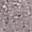

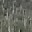

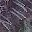

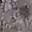

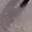

In [32]:
#let's look at some images
import os
from IPython.display import Image, display


for file in os.listdir("train/")[:5]:
  
  display(Image(filename="/content/train/"+file))


In [33]:
path_img = "/content/train/"
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/train/6674b1dbbdabb4b33fd58c0adba8dbba.jpg'),
 PosixPath('/content/train/4f095604498b4cc16769cf6f0712d68c.jpg'),
 PosixPath('/content/train/5ff4bcd43dc73864b1928d7d28c82b2d.jpg'),
 PosixPath('/content/train/44bd9440125b822eff330eb02faf15dd.jpg'),
 PosixPath('/content/train/be65f085ed03090eebc2b511b8a75cb3.jpg')]

In [34]:
#Let's look at annotation file
import pandas as pd
ann = pd.read_csv("train.csv")
ann.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


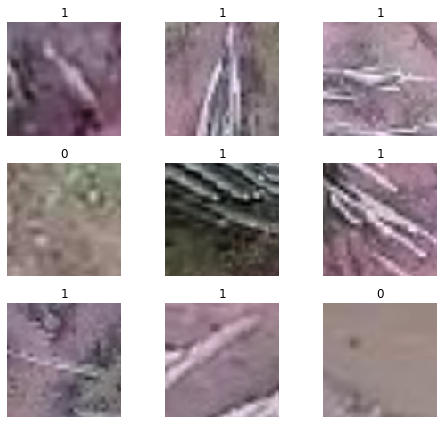

In [43]:
test_df = pd.read_csv("/content/sample_submission.csv")
train_df = pd.read_csv("/content/train.csv")
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
test_img = ImageList.from_df(test_df, path= "/content/", folder='test')
data = (ImageList.from_df(train_df,path= "/content/", folder='train')
                                .split_by_rand_pct(0.01)
                                .label_from_df()
                                .add_test(test_img)
                                .transform(trfm, size=128)
                                .databunch(path='.', bs=64, device= torch.device('cuda:0'))
                                .normalize(imagenet_stats)
      )
data.show_batch(rows=3, figsize=(7,6))

In [44]:
print(data.classes)

[0, 1]


- Training : resnet34
- We will train for 4 epochs (4 cycles through all our data).


In [45]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [46]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.153968,0.048368,0.028571,00:49
1,0.071880,0.007741,0.000000,00:49
2,0.051522,0.011239,0.000000,00:49
3,0.042700,0.008158,0.000000,00:48


In [0]:
learn.save('stage-1')

- Results

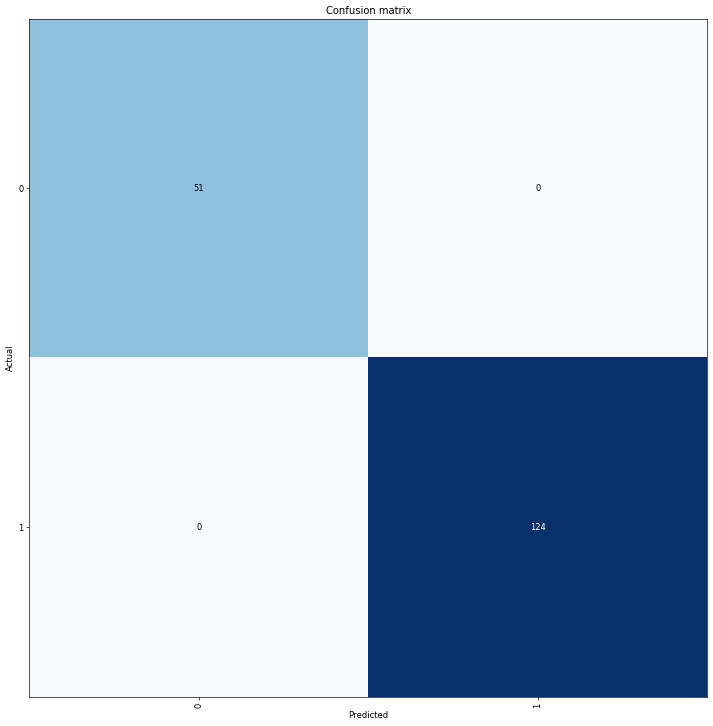

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Comments:


- This model is working as expected and let's try to improve!



In [49]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.026311,0.004129,0.000000,00:51


- Looks nice!

In [50]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
test_df.has_cactus = preds.numpy()[:, 0]
test_df.to_csv('submission.csv', index=False)

In [30]:
ss = pd.read_csv("sample_submission.csv")
ss.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [31]:
learn.data.batch_size

64